# Introduction : Imports et préparation du dataset

In [56]:
from gurobipy import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [57]:
# Import des poids
df_weights = pd.read_excel(
    "RATP.xlsx",
    usecols="C:I",
    skiprows=13,
    nrows=1,
) # type: ignore

# Imports des données pour chaque station
data = pd.read_excel(
    "RATP.xlsx",
    usecols="B:I",
    skiprows=2,
    nrows=10,
    index_col=0,
)

# Réécriture des poids dans un dictionnaire
df_weights.columns = data.columns

weights = df_weights.iloc[0].to_dict()
stations = data.to_dict(orient="index")

def get_station(station_name: str) -> pd.Series:
    return stations[station_name] # type: ignore

print("Données chargées :")
print("Stations :", list(stations.keys()))
print("Poids :", weights)

Données chargées :
Stations : ['Odéon (Ligne 4)', "Place d'Italie (Lign 6)", 'Jussieu (Ligne 7)', 'Nation (Ligne 9)', 'La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Daumenil (Ligne 6)', 'Vaugirard (Ligne 12)', 'Oberkampf (Ligne 9)', 'Reuilly-Diderot (Ligne 1)']
Poids : {'peak-entering-passengers/h': 0.02149844136300118, 'peak-passing-passengers/h': 0.18811136192626035, 'off-peak-entering-passengers/h': 0.03762227238525207, 'off-peak-passing-passengers/h': 0.3224766204450177, 'strategic priority [0,10]': 16.123831022250886, 'Station degradation level ([0,20]  scale)': 67.18262925937869, 'connectivity index [0,100]': 16.123831022250886}


Graphe des stations créé avec les nœuds :


C:\Users\natha\AppData\Local\Temp\ipykernel_22688\173074288.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


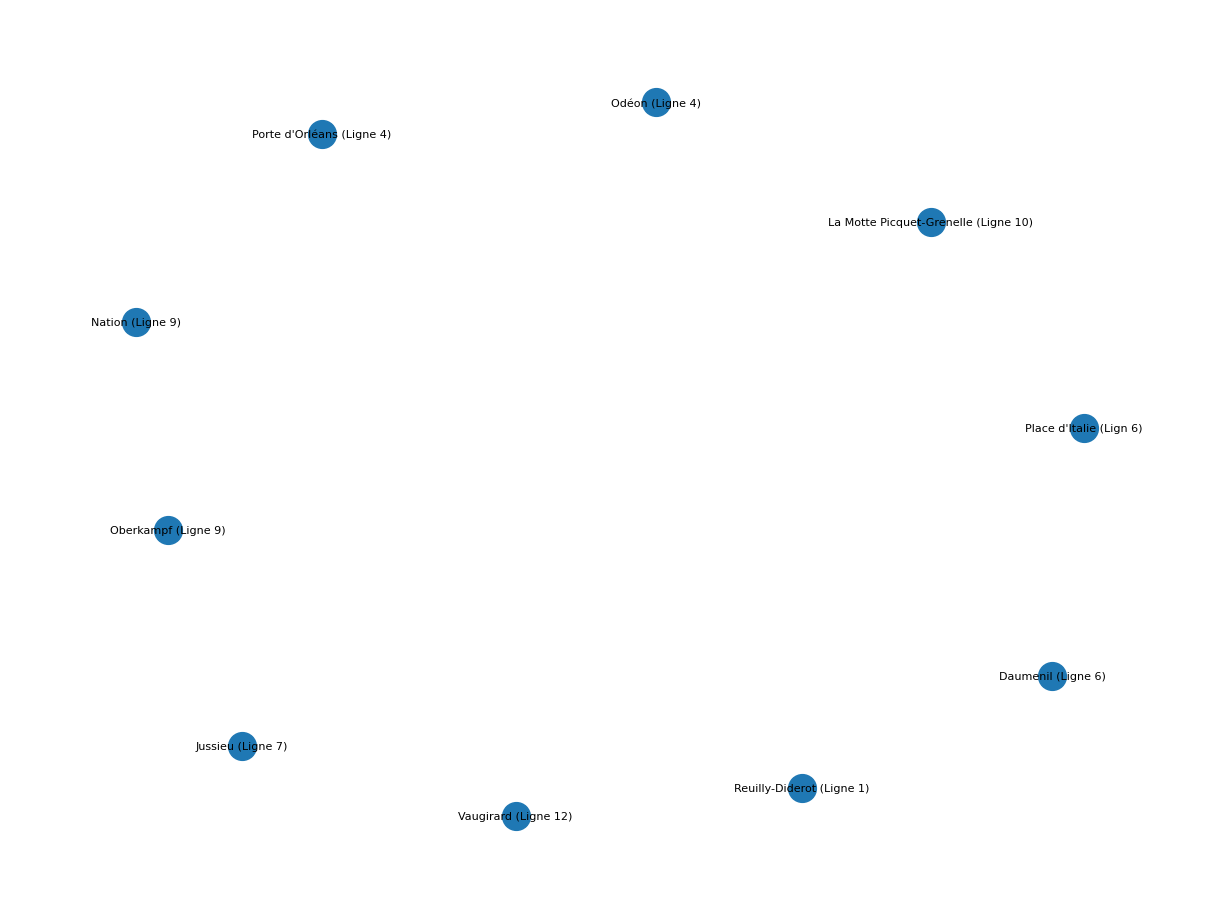

In [58]:
# Création d'un graphe pour représenter les stations et leurs relations de comparaison
stations_graph = nx.DiGraph()
for station_name, _ in stations.items():
    stations_graph.add_node(station_name, label=station_name)
    
print("Graphe des stations créé avec les nœuds :")

def show_stations_graph(graphe: nx.DiGraph = stations_graph) -> None:
    pos = nx.spring_layout(graphe, seed=42, k=1.2)
    plt.figure(figsize=(12, 9))
    nx.draw(graphe, pos, with_labels=True, node_size=400, font_size=8, arrows=True)
    # marge manuelle pour "dézoomer"
    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    pad = 0.25
    plt.xlim(min(xs) - pad, max(xs) + pad)
    plt.ylim(min(ys) - pad, max(ys) + pad)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
show_stations_graph()

# Explication de type (1-m)

Pour chaque paire de stations, on effectue une analyse (1-m) pour vérifier l'existence d'une explication satisfaisante.

Si une explication existe pour la comparaison $station_{u} > station_{v}$, on ajoute l'arrête $station_{u} \rightarrow station_{v}$ dans le graphe.


Analyse (1-m) pour la paire (Odéon (Ligne 4) > Place d'Italie (Lign 6)) :
Comparaison {'peak-entering-passengers/h': 85000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 35500, 'off-peak-passing-passengers/h': 3450, 'strategic priority [0,10]': 75, 'Station degradation level ([0,20]  scale)': 16.2, 'connectivity index [0,100]': 88} > {'peak-entering-passengers/h': 81000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 37500, 'off-peak-passing-passengers/h': 3150, 'strategic priority [0,10]': 67, 'Station degradation level ([0,20]  scale)': 17.6, 'connectivity index [0,100]': 95}
Arguments Pour (Pros) : ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
Arguments Contre (Cons) : ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
Deltas : {'peak-entering-passengers/h': 85.99376545200472, 'peak-passing-passengers/h': 0.0, 'off-peak-entering-pass

C:\Users\natha\AppData\Local\Temp\ipykernel_22688\173074288.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


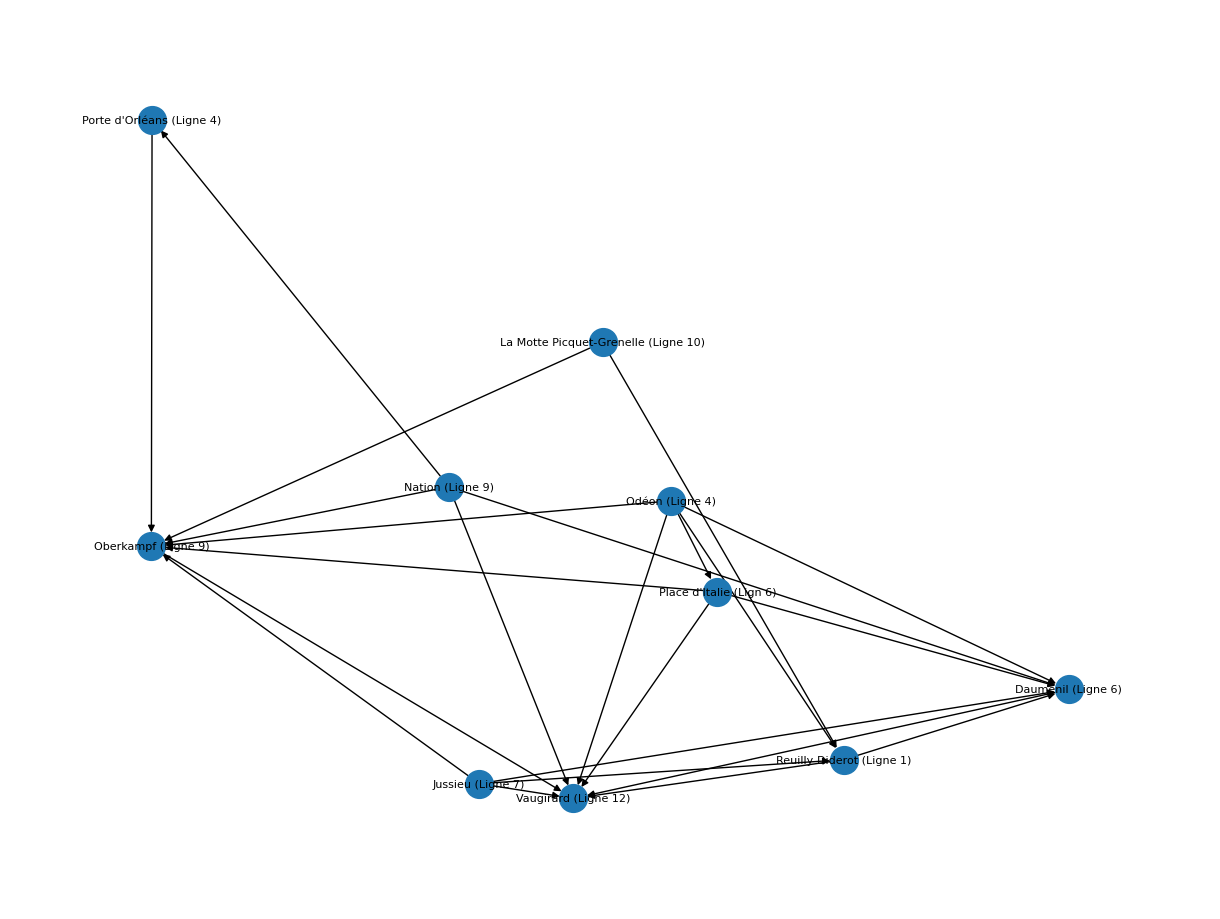

In [59]:
def compare_1_m(station_1, station_2):

    # DONNÉES (Comparaison u > v)
    station_1 = get_station(station_1)
    station_2 = get_station(station_2)

    # Calcul des contributions (deltas)
    deltas = {}
    for k in weights:
        deltas[k] = weights[k] * (station_1[k] - station_2[k])

    # Calcul des contributions (deltas)
    deltas = {}
    for k in weights:
        deltas[k] = weights[k] * (station_1[k] - station_2[k])

    pros = [k for k, v in deltas.items() if v > 0]
    cons = [k for k, v in deltas.items() if v < 0]

    print(f"Comparaison {station_1} > {station_2}")
    print(f"Arguments Pour (Pros) : {pros}")
    print(f"Arguments Contre (Cons) : {cons}")
    print(f"Deltas : {deltas}")

    # MODÉLISATION GUROBI
    m = Model("Explication_1_m")

    # Variables de décision UNIQUEMENT x
    # x[p, c] = 1 si l'argument Pro 'p' couvre l'argument Con 'c'
    x = m.addVars(pros, cons, vtype=GRB.BINARY, name="x")

    m.update()

    # CONTRAINTES

    # A. Couverture complète : Chaque Con doit être couvert par exactement un Pro
    for c in cons:
        m.addConstr(quicksum(x[p, c] for p in pros) == 1, name=f"Cover_{c}")

    # B. Validité du Trade-off
    # Formule : Delta_p + Somme(Delta_c * x_pc) >= epsilon
    # Si p est utilisé, cela vérifie que le trade-off est positif.
    # Si p est INUTILISÉ (x_pc = 0 partout), cela devient Delta_p >= epsilon, ce qui est toujours VRAI.
    epsilon = 0.001 

    for p in pros:
        # Note: deltas[c] est négatif ici
        m.addConstr(deltas[p] + quicksum(deltas[c] * x[p, c] for c in cons) >= epsilon, name=f"Valid_{p}")

    # RÉSOLUTION
    m.params.outputflag = 0  
    m.optimize()

    # ANALYSE
    print("-" * 30)
    if m.status == GRB.OPTIMAL:
        print("Résultat : Une explication de type (1-m) existe !\n")
        
        # Pour chaque Con, on affiche les Pros qui le couvrent
        for c in cons:
            assigned_pros = [p for p in pros if x[p, c].x > 0.5]
            
            sum_pros = sum(deltas[p] for p in assigned_pros)
            net_value = deltas[c] + sum_pros
            
            print(f"Argument Contre {c} ({deltas[c]}) compensé par :")
            print(f"  -> Pros : {assigned_pros} (Cumul Pros: +{sum_pros})")
            print(f"  -> Bilan net : +{net_value}")
            print("")
            
        return True

    elif m.status == GRB.INFEASIBLE:
        print("Résultat : INFEASIBLE (Certificat de non-existence).")
        
        return False

stations_graph_1_m = stations_graph.copy()    
for u in stations.keys():
    for v in stations.keys():
        if u == v:
            continue
        
        print(f"\nAnalyse (1-m) pour la paire ({u} > {v}) :")
        res = compare_1_m(u, v)
        print(res)
        
        if res:
            stations_graph_1_m.add_edge(u, v)
            
show_stations_graph(stations_graph_1_m)

# Explication de type (m-1)

Pour chaque paire de station, on effectue une analyse (1-m) pour vérifier l'existence d'une explication suffisante.

Si une explication existe pour la comparaison $station_{u} > station_{v}$, on ajoute l'arrête $station_{u} \rightarrow station_{v}$ dans le graphe.


Analyse (m-1) pour la paire (Odéon (Ligne 4) > Place d'Italie (Lign 6)) :
Comparaison {'peak-entering-passengers/h': 85000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 35500, 'off-peak-passing-passengers/h': 3450, 'strategic priority [0,10]': 75, 'Station degradation level ([0,20]  scale)': 16.2, 'connectivity index [0,100]': 88} > {'peak-entering-passengers/h': 81000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 37500, 'off-peak-passing-passengers/h': 3150, 'strategic priority [0,10]': 67, 'Station degradation level ([0,20]  scale)': 17.6, 'connectivity index [0,100]': 95}
Arguments Pour (Pros) : ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
Arguments Contre (Cons) : ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
Deltas : {'peak-entering-passengers/h': 85.99376545200472, 'peak-passing-passengers/h': 0.0, 'off-peak-entering-pass

C:\Users\natha\AppData\Local\Temp\ipykernel_22688\173074288.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


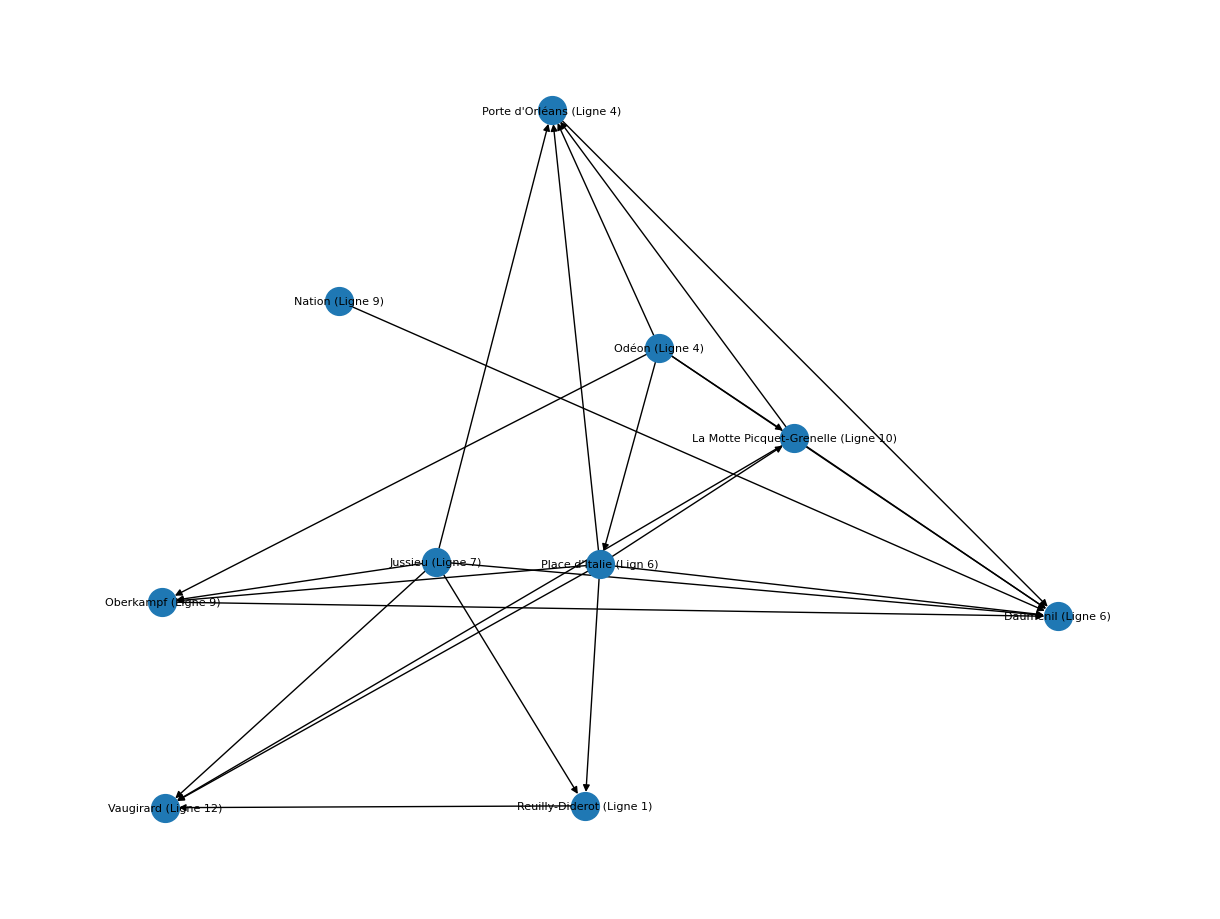

In [60]:
def compare_m_1(station_1, station_2):

    # DONNÉES (Comparaison 1 > 2)
    station_1 = get_station(station_1)
    station_2 = get_station(station_2)

    # Calcul des contributions (deltas)
    deltas = {}
    for k in weights:
        deltas[k] = weights[k] * (station_1[k] - station_2[k])

    pros = [k for k, v in deltas.items() if v > 0]
    cons = [k for k, v in deltas.items() if v < 0]

    print(f"Comparaison {station_1} > {station_2}")
    print(f"Arguments Pour (Pros) : {pros}")
    print(f"Arguments Contre (Cons) : {cons}")
    print(f"Deltas : {deltas}")

    # MODÉLISATION GUROBI (m-1)
    m = Model("Explication_m_1")

    # Variables de décision x[p, c]
    # x[p, c] = 1 si l'argument Pro 'p' est utilisé pour couvrir l'argument Con 'c'
    x = m.addVars(pros, cons, vtype=GRB.BINARY, name="x")

    m.update()

    # CONTRAINTES

    # 1. Disjonction des Pros : Chaque Pro peut être utilisé au plus une fois
    for p in pros:
        m.addConstr(quicksum(x[p, c] for c in cons) <= 1, name=f"Unique_{p}")

    # 2. Validité des Trade-offs : Chaque Con 'c' doit être compensé par un groupe de Pros
    # Formule : Delta_c + Somme(Delta_p * x_pc) >= epsilon
    epsilon = 0.001

    for c in cons:
        # Note: deltas[c] est négatif
        m.addConstr(deltas[c] + quicksum(deltas[p] * x[p, c] for p in pros) >= epsilon, name=f"Valid_Group_for_{c}")

    # Fonction Objectif : Ici on cherche juste la faisabilité (Objectif constant)
    m.setObjective(0, GRB.MINIMIZE)

    # Paramétrage
    m.params.outputflag = 0
    m.optimize()

    # ANALYSE DES RÉSULTATS
    print("-" * 30)
    if m.status == GRB.OPTIMAL:
        print("Résultat : Une explication de type (m-1) existe !\n")
        
        # Pour chaque Con, on affiche les Pros qui le couvrent
        for c in cons:
            assigned_pros = [p for p in pros if x[p, c].x > 0.5]
            
            sum_pros = sum(deltas[p] for p in assigned_pros)
            net_value = deltas[c] + sum_pros
            
            print(f"Argument Contre {c} ({deltas[c]}) compensé par :")
            print(f"  -> Pros : {assigned_pros} (Cumul Pros: +{sum_pros})")
            print(f"  -> Bilan net : +{net_value}")
            print("")
            
        return True

    elif m.status == GRB.INFEASIBLE:
        print("Résultat : INFEASIBLE (Pas d'explication de type (m-1)).")
        
        return False
    
    
stations_graph_m_1 = stations_graph.copy()
for u in data.index:
    for v in data.index:
        if u == v:
            continue
        
        print(f"\nAnalyse (m-1) pour la paire ({u} > {v}) :")
        res = compare_m_1(u, v)
        
        if res:
            stations_graph_m_1.add_edge(u, v)
            
show_stations_graph(stations_graph_m_1)

# Eplication mixte de type (1-m) ou (m-1)

Pour chaque paire de stations, on effectue une analyse mixte pour vérifier l'existence d'une explication satisfaisante.

Si une explication existe pour la comparaison $station_{u} > station_{v}$, on ajoute l'arrête $station_{u} \rightarrow station_{v}$ dans le graphe.


Analyse mixte pour la paire (Odéon (Ligne 4) > Place d'Italie (Lign 6)) :
Comparaison {'peak-entering-passengers/h': 85000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 35500, 'off-peak-passing-passengers/h': 3450, 'strategic priority [0,10]': 75, 'Station degradation level ([0,20]  scale)': 16.2, 'connectivity index [0,100]': 88} > {'peak-entering-passengers/h': 81000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 37500, 'off-peak-passing-passengers/h': 3150, 'strategic priority [0,10]': 67, 'Station degradation level ([0,20]  scale)': 17.6, 'connectivity index [0,100]': 95}
Arguments Pour (Pros) : ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
Arguments Contre (Cons) : ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
Deltas : {'peak-entering-passengers/h': 85.99376545200472, 'peak-passing-passengers/h': 0.0, 'off-peak-entering-pass

C:\Users\natha\AppData\Local\Temp\ipykernel_22688\173074288.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


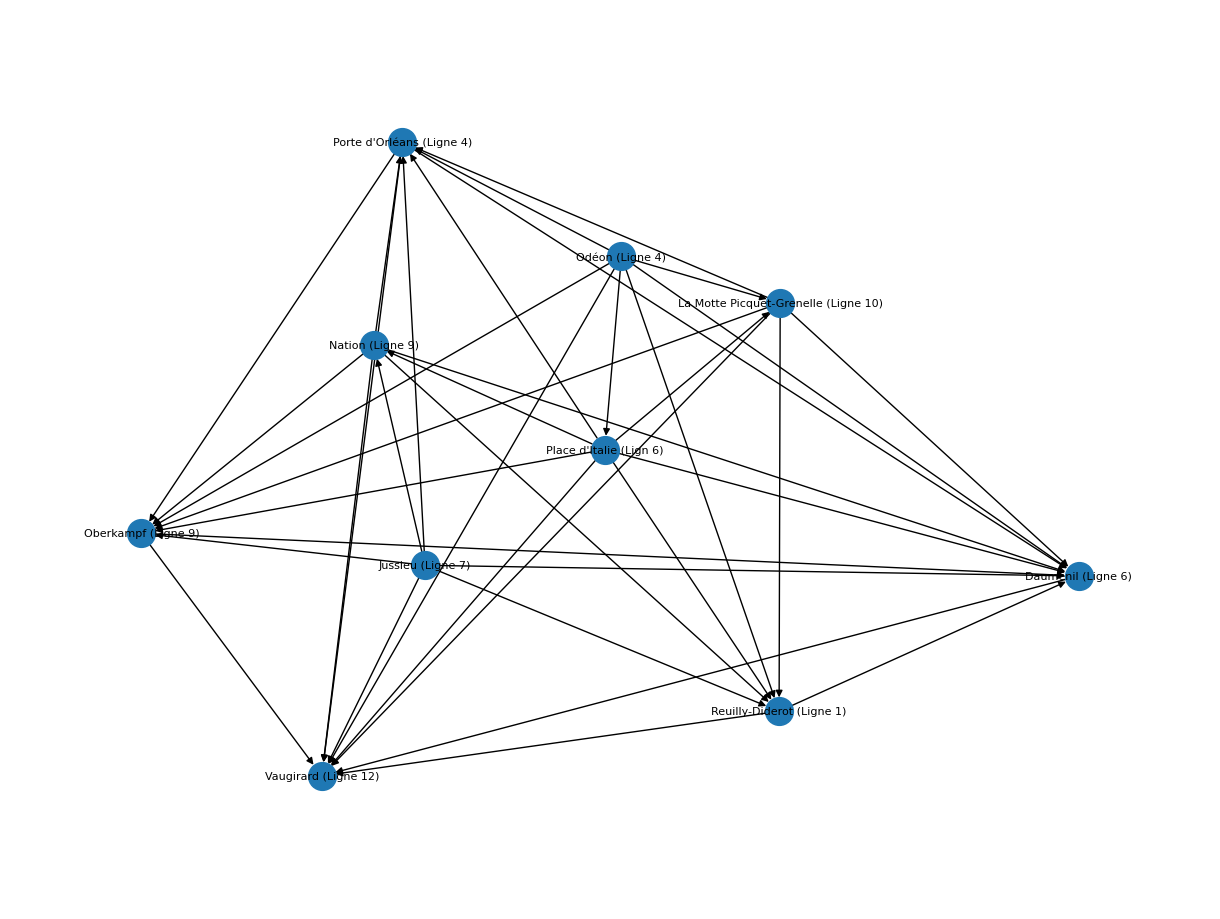

In [61]:
def mixt_compare(station_1, station_2):
    
    # DONNÉES Comparaison 1 > 2
    station_1 = get_station(station_1)
    station_2 = get_station(station_2)

    # Calcul des contributions
    deltas = {}
    for k in weights:
        deltas[k] = weights[k] * (station_1[k] - station_2[k])

    pros = [k for k, v in deltas.items() if v > 0]
    cons = [k for k, v in deltas.items() if v < 0]

    print(f"Comparaison {station_1} > {station_2}")
    print(f"Arguments Pour (Pros) : {pros}")
    print(f"Arguments Contre (Cons) : {cons}")
    print(f"Deltas : {deltas}")

    # MODÈLE MIXTE
    m = Model("Explication_Mixte")

    # Variables
    z_1m = m.addVars(pros, vtype=GRB.BINARY, name="z_1m")  # p est pivot 1-m
    z_m1 = m.addVars(cons, vtype=GRB.BINARY, name="z_m1")  # c est pivot m-1

    v = m.addVars(pros, cons, vtype=GRB.BINARY, name="v") # relation dans 1-m (p couvre c)
    w = m.addVars(pros, cons, vtype=GRB.BINARY, name="w") # relation dans m-1 (p aide c)

    m.update()

    # CONTRAINTES

    # 1. Couverture des Cons
    # Chaque c est soit un pivot m-1, soit couvert par un p en mode 1-m
    for c in cons:
        m.addConstr(z_m1[c] + quicksum(v[p, c] for p in pros) == 1, name=f"CoverCons_{c}")

    # 2. Utilisation unique des Pros
    # Chaque p est soit un pivot 1-m, soit un support m-1 (ou rien)
    for p in pros:
        m.addConstr(z_1m[p] + quicksum(w[p, c] for c in cons) <= 1, name=f"UniquePro_{p}")

    # 3. Consistance des liens
    # Si p couvre c en 1-m (v[p,c]=1), alors p doit être un pivot 1-m
    for p in pros:
        for c in cons:
            m.addConstr(v[p, c] <= z_1m[p])

    # Si p aide c en m-1 (w[p,c]=1), alors c doit être un pivot m-1
    for p in pros:
        for c in cons:
            m.addConstr(w[p, c] <= z_m1[c])

    # 4. Validité des groupes (Solvabilité budgétaire)
    epsilon = 0.001
    BigM = 1000

    # Pour chaque p pivot 1-m : Delta_p + Somme(Delta_c) > 0
    for p in pros:
        # Si z_1m[p] = 0, la contrainte est relâchée ( >= -1000 )
        m.addConstr(deltas[p] + quicksum(deltas[c] * v[p, c] for c in cons) >= epsilon - BigM * (1 - z_1m[p]))

    # Pour chaque c pivot m-1 : Delta_c + Somme(Delta_p) > 0
    for c in cons:
        # Si z_m1[c] = 0, la contrainte est relâchée
        m.addConstr(deltas[c] + quicksum(deltas[p] * w[p, c] for p in pros) >= epsilon - BigM * (1 - z_m1[c]))

    # Objectif : Minimiser le nombre de pivots (pour avoir une explication compacte) ou juste Feasibility
    # Essayons de minimiser le nombre total de trade-offs
    m.setObjective(quicksum(z_1m[p] for p in pros) + quicksum(z_m1[c] for c in cons), GRB.MINIMIZE)
    m.params.outputflag = 0
    m.optimize()

    # RÉSULTATS
    print("-" * 30)
    if m.status == GRB.OPTIMAL:
        print("Solution Mixte trouvée !\n")
        
        # Affichage des trade-offs (1-m)
        for p in pros:
            if z_1m[p].x > 0.5:
                my_cons = [c for c in cons if v[p, c].x > 0.5]
                val = deltas[p] + sum(deltas[c] for c in my_cons)
                print(f"[Type 1-m] Le Pro '{p}' ({deltas[p]}) couvre les Cons {my_cons} (Net: +{val})")

        # Affichage des trade-offs (m-1)
        for c in cons:
            if z_m1[c].x > 0.5:
                my_pros = [p for p in pros if w[p, c].x > 0.5]
                val = deltas[c] + sum(deltas[p] for p in my_pros)
                print(f"[Type m-1] Le Con '{c}' ({deltas[c]}) est compensé par les Pros {my_pros} (Net: +{val})")
                
        return True
                
    elif m.status == GRB.INFEASIBLE:
        print("INFEASIBLE. Pas d'explication mixte possible.")
        
        return False


for u in data.index:
    for v in data.index:
        if u == v:
            continue
        
        print(f"\nAnalyse mixte pour la paire ({u} > {v}) :")
        res = mixt_compare(u, v)
        
        if res:
            stations_graph.add_edge(u, v)
            
show_stations_graph()

# Conclusion : Récupération de la station prioritaire pour être rénovée

Après avoir lancer l'analyse mixte qui est la synthèse des deux analyses précédentes, on obtient naturellement toutes les paires pour lesquelles il est possible d'expliquer qu'une station est prioritaire sur l'autre.

Il est donc possible de comparer les résultats de toutes les paires pour trouver les stations prioritaires, et le cas échéant, afficher une explication.

Nombre d'éléments maximaux : 2
Éléments maximaux : ['Odéon (Ligne 4)', 'Jussieu (Ligne 7)']
- Détails pour l'élément maximal 'Odéon (Ligne 4)':


C:\Users\natha\AppData\Local\Temp\ipykernel_22688\173074288.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


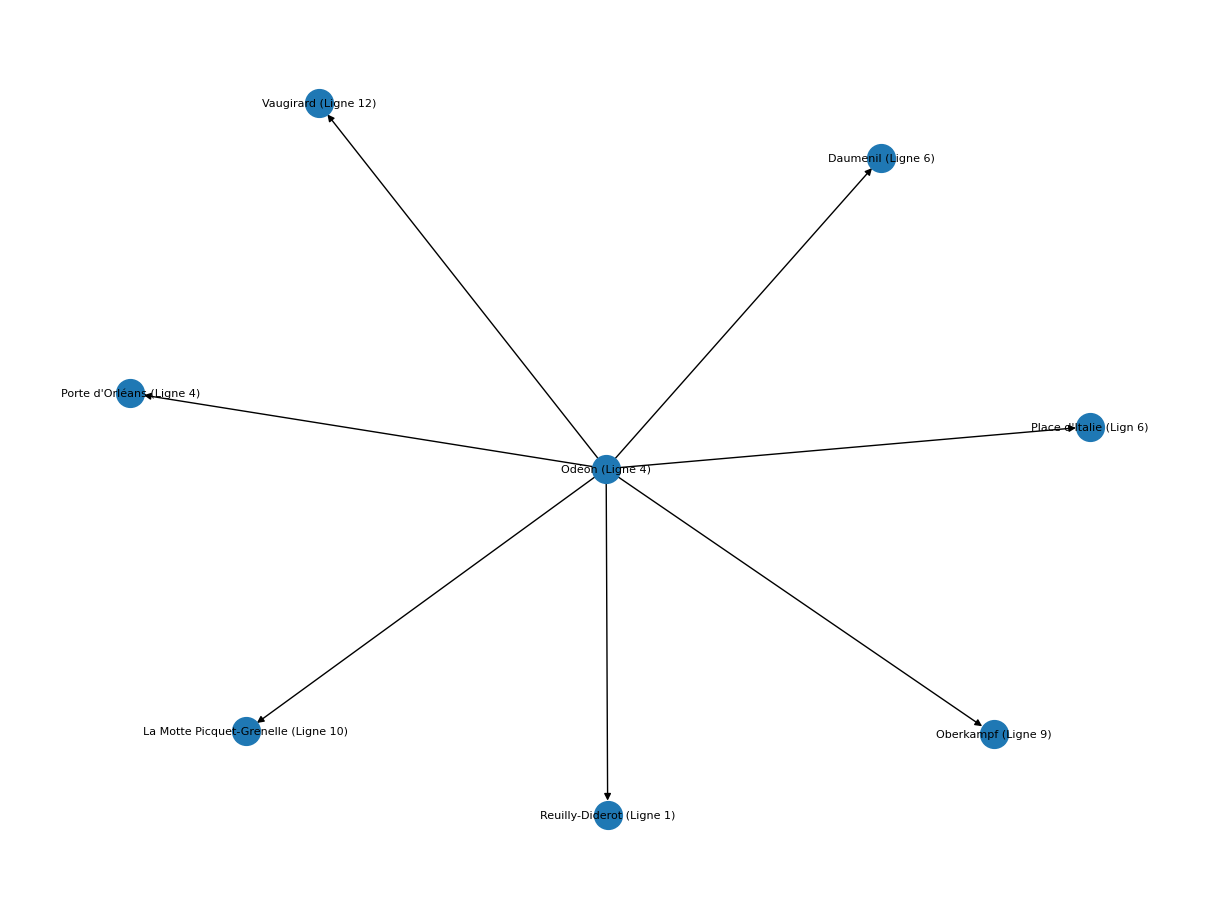

- Détails pour l'élément maximal 'Jussieu (Ligne 7)':


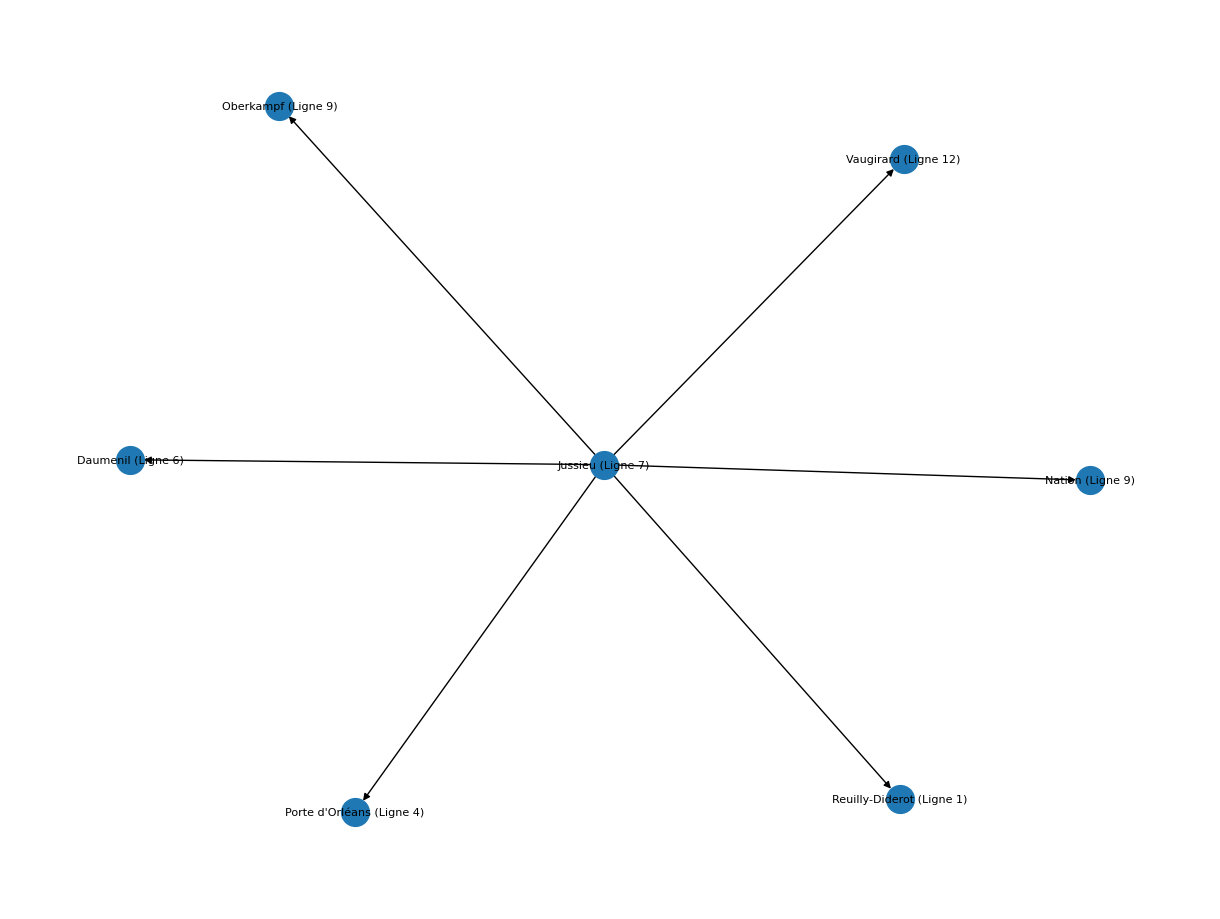

In [62]:
# Trouveur d'éléments maximaux
def maximal_elements(graph_results):
    
    # Un nœud est maximal s'il n'a aucun prédécesseur (indegree = 0)
    elements = [node for node, indeg in graph_results.in_degree() if indeg == 0]
    
    if elements:
        print(f"Nombre d'éléments maximaux : {len(elements)}")
        print(f"Éléments maximaux : {elements}")
        
        for elem in elements:
            print(f"- Détails pour l'élément maximal '{elem}':")
            sub_graph = nx.DiGraph()
            sub_graph.add_node(elem, label=elem)
            for edge in graph_results.edges:
                if edge[0] == elem:
                    sub_graph.add_edge(edge[0], edge[1])
            show_stations_graph(sub_graph) # type: ignore
    else:
        print("Aucun élément maximal (cycle ou dominance complète)")
    
    return elements


prioritary_stations = maximal_elements(stations_graph)

In [63]:
def explication_element_maximal(element_maximal, data, weights):
    
    print(f"\nExplications pour l'élément maximal : {element_maximal}")
    for v in stations_graph.successors(element_maximal):
        print(f"\nAnalyse mixte pour la paire ({element_maximal} > {v}) :")
        mixt_compare(element_maximal, v)
        
for u in prioritary_stations:
    explication_element_maximal(u, data, weights)


Explications pour l'élément maximal : Odéon (Ligne 4)

Analyse mixte pour la paire (Odéon (Ligne 4) > Place d'Italie (Lign 6)) :
Comparaison {'peak-entering-passengers/h': 85000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 35500, 'off-peak-passing-passengers/h': 3450, 'strategic priority [0,10]': 75, 'Station degradation level ([0,20]  scale)': 16.2, 'connectivity index [0,100]': 88} > {'peak-entering-passengers/h': 81000, 'peak-passing-passengers/h': 8100, 'off-peak-entering-passengers/h': 37500, 'off-peak-passing-passengers/h': 3150, 'strategic priority [0,10]': 67, 'Station degradation level ([0,20]  scale)': 17.6, 'connectivity index [0,100]': 95}
Arguments Pour (Pros) : ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
Arguments Contre (Cons) : ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
Deltas : {'peak-entering-passengers/h': 85.99376545200472, 'p